In [1]:
import pandas as pd
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [2]:
conn = sqlite3.connect('src/database/app.db')
df = pd.read_sql_query('SELECT * FROM recognition_log', conn)
conn.close()

In [3]:
df.head()

,id,detected_at,ip,status,light_level,recognized,user_id,confidence,latency_ms
0,1,2025-11-15 10:42:36.774227,10.0.0.190,no_face,54.380404,0,NaN,NaN,743.800
1,2,2025-11-15 10:42:36.949417,10.0.0.190,no_face,54.738359,0,NaN,NaN,114.479
2,3,2025-11-15 10:42:45.611430,10.0.0.190,no_face,65.999271,0,NaN,NaN,3401.066
3,4,2025-11-15 10:43:02.210438,10.0.0.190,no_face,64.193008,0,NaN,NaN,854.183
4,5,2025-11-15 10:43:03.262773,10.0.0.190,no_face,72.686432,0,NaN,NaN,604.436


In [4]:
def adicionar_faixas_iluminacao(df: pd.DataFrame) -> pd.DataFrame:
    # ajuste os limites conforme seu cenário/câmera
    bins = [0, 30, 60, 100, 150, 255, float("inf")]
    labels = [
        "0–30 (muito escuro)",
        "30–60 (escuro)",
        "60–100 (ok)",
        "100–150 (claro)",
        "150–255 (muito claro)",
        ">=255 (estourado)"
    ]
    df = df.copy()
    df["faixa_luz"] = pd.cut(df["light_level"], bins=bins, labels=labels, right=True, include_lowest=True)
    return df

In [5]:
def grafico_barras_empilhadas_por_luz(df: pd.DataFrame, titulo: str = "Tipos de detecção por faixa de luminosidade"):
    # tabela de contagem
    ct = pd.crosstab(df["faixa_luz"], df["status"]).fillna(0).astype(int)

    # garante ordem lógica dos rótulos das faixas
    categorias_ordem = [c for c in [
        "0–30 (muito escuro)", "30–60 (escuro)", "60–100 (ok)",
        "100–150 (claro)", "150–255 (muito claro)", ">=255 (estourado)"
    ] if c in ct.index]
    ct = ct.reindex(categorias_ordem)

    # plot
    ax = ct.plot(kind="bar", stacked=True, figsize=(10, 5))
    ax.set_title(titulo)
    ax.set_xlabel("Faixa de luminosidade")
    ax.set_ylabel("Quantidade de detecções")
    ax.legend(title="Status", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

In [6]:
def grafico_percentual_por_luz(df: pd.DataFrame, titulo: str = "Proporção de tipos de detecção por faixa de luminosidade"):
    ct = pd.crosstab(df["faixa_luz"], df["status"]).astype(float)
    pct = (ct.T / ct.sum(axis=1)).T * 100.0
    categorias_ordem = [c for c in [
        "0–30 (muito escuro)", "30–60 (escuro)", "60–100 (ok)",
        "100–150 (claro)", "150–255 (muito claro)", ">=255 (estourado)"
    ] if c in pct.index]
    pct = pct.reindex(categorias_ordem)

    ax = pct.plot(kind="bar", stacked=True, figsize=(10, 5))
    ax.set_title(titulo)
    ax.set_xlabel("Faixa de luminosidade")
    ax.set_ylabel("% dentro da faixa")
    ax.legend(title="Status", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

In [7]:
df = adicionar_faixas_iluminacao(df)
df.head()

,id,detected_at,ip,status,light_level,recognized,user_id,confidence,latency_ms,faixa_luz
0,1,2025-11-15 10:42:36.774227,10.0.0.190,no_face,54.380404,0,NaN,NaN,743.800,30–60 (escuro)
1,2,2025-11-15 10:42:36.949417,10.0.0.190,no_face,54.738359,0,NaN,NaN,114.479,30–60 (escuro)
2,3,2025-11-15 10:42:45.611430,10.0.0.190,no_face,65.999271,0,NaN,NaN,3401.066,60–100 (ok)
3,4,2025-11-15 10:43:02.210438,10.0.0.190,no_face,64.193008,0,NaN,NaN,854.183,60–100 (ok)
4,5,2025-11-15 10:43:03.262773,10.0.0.190,no_face,72.686432,0,NaN,NaN,604.436,60–100 (ok)


In [8]:
df["timestamp"] = pd.to_datetime(df["detected_at"])

In [9]:
df.head()

,id,detected_at,ip,status,light_level,recognized,user_id,confidence,latency_ms,faixa_luz,timestamp
0,1,2025-11-15 10:42:36.774227,10.0.0.190,no_face,54.380404,0,NaN,NaN,743.800,30–60 (escuro),2025-11-15 10:42:36.774227
1,2,2025-11-15 10:42:36.949417,10.0.0.190,no_face,54.738359,0,NaN,NaN,114.479,30–60 (escuro),2025-11-15 10:42:36.949417
2,3,2025-11-15 10:42:45.611430,10.0.0.190,no_face,65.999271,0,NaN,NaN,3401.066,60–100 (ok),2025-11-15 10:42:45.611430
3,4,2025-11-15 10:43:02.210438,10.0.0.190,no_face,64.193008,0,NaN,NaN,854.183,60–100 (ok),2025-11-15 10:43:02.210438
4,5,2025-11-15 10:43:03.262773,10.0.0.190,no_face,72.686432,0,NaN,NaN,604.436,60–100 (ok),2025-11-15 10:43:03.262773


In [22]:
distinct_items_per_category = df.groupby('user_id')['id'].nunique()

In [24]:
a = df.groupby('status')['id'].count()
a

status
no_face       353
recognized    270
unknown         1
Name: id, dtype: int64

In [23]:
distinct_items_per_category

user_id
1.0     269
32.0      1
Name: id, dtype: int64

In [10]:
df.shape

(624, 11)

In [11]:
df.dtypes

id                      int64
detected_at            object
ip                     object
status                 object
light_level           float64
recognized              int64
user_id               float64
confidence            float64
latency_ms            float64
faixa_luz            category
timestamp      datetime64[ns]
dtype: object

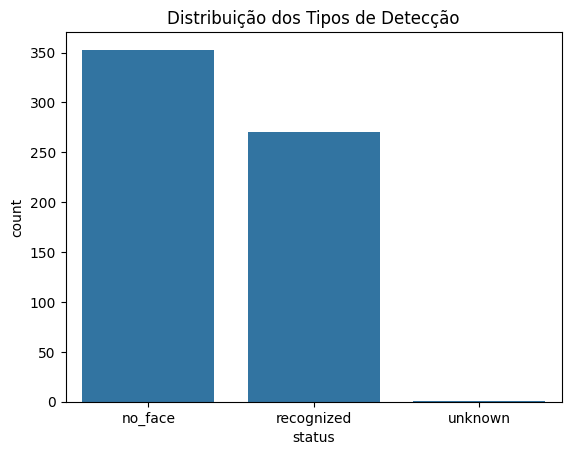

In [12]:
# Distribuição de status
sns.countplot(data=df, x='status')
plt.title('Distribuição dos Tipos de Detecção')
plt.show()

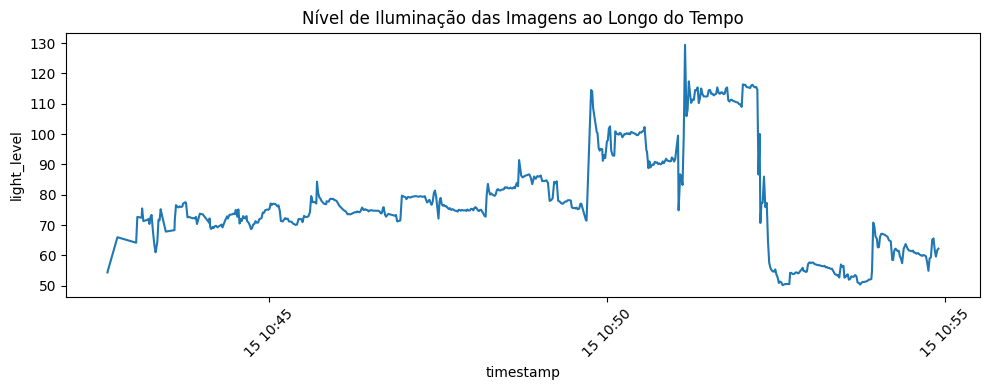

In [13]:
# Iluminação ao longo do tempo
plt.figure(figsize=(10, 4))
sns.lineplot(data=df, x='timestamp', y='light_level')
plt.title('Nível de Iluminação das Imagens ao Longo do Tempo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

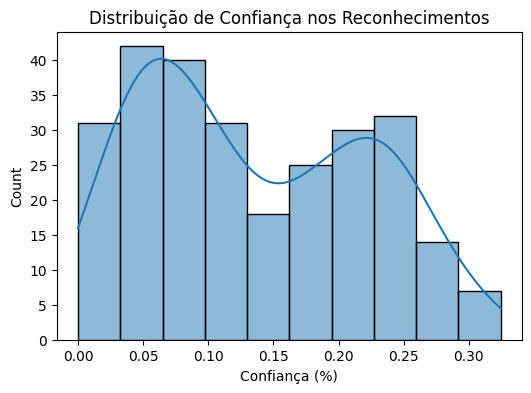

In [14]:
# Confiança dos reconhecimentos (quando disponível)
df_conf = df[df['confidence'].notnull()]
plt.figure(figsize=(6, 4))
sns.histplot(df_conf['confidence'], bins=10, kde=True)
plt.title('Distribuição de Confiança nos Reconhecimentos')
plt.xlabel('Confiança (%)')
plt.show()

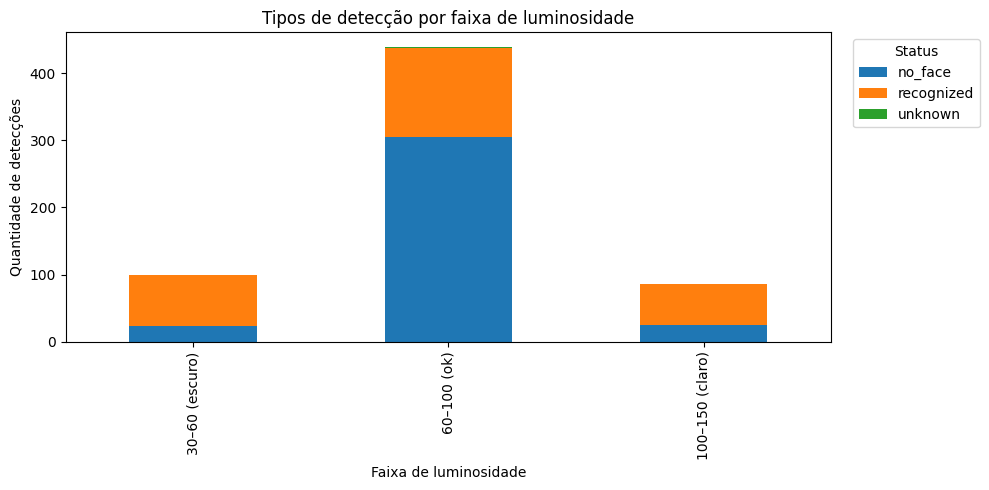

In [15]:
grafico_barras_empilhadas_por_luz(df)

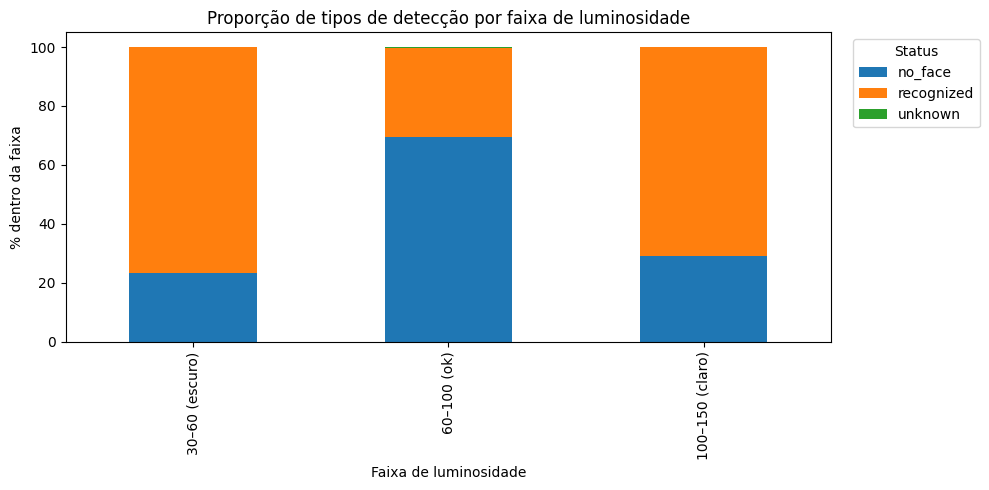

In [16]:
grafico_percentual_por_luz(df)

In [17]:
# Conta os registros em cada faixa
contagem = df["faixa_luz"].value_counts().sort_index()

print(contagem)

faixa_luz
0–30 (muito escuro)        0
30–60 (escuro)            99
60–100 (ok)              439
100–150 (claro)           86
150–255 (muito claro)      0
>=255 (estourado)          0
Name: count, dtype: int64


In [18]:
# 1) Ordena por timestamp para garantir sequência correta
df = df.sort_values("timestamp")

# 2) Calcula a diferença de tempo entre requisições
df["tempo_entre_requisicoes"] = df["timestamp"].diff()

# Tempo médio entre requisições
tempo_medio_requisicoes = df["tempo_entre_requisicoes"].mean()
print("Tempo médio entre requisições:", tempo_medio_requisicoes)

# Em segundos
print("Tempo médio (s):", tempo_medio_requisicoes.total_seconds())

Tempo médio entre requisições: 0 days 00:00:01.183272014
Tempo médio (s): 1.183272


In [19]:
# 3) Tempo médio de latência (resposta do Flask)
tempo_medio_latencia = df["latency_ms"].mean()
print("Tempo médio de latência (ms):", tempo_medio_latencia)

# 4) Estatísticas extras
print("Latência mínima (ms):", df["latency_ms"].min())
print("Latência máxima (ms):", df["latency_ms"].max())

Tempo médio de latência (ms): 564.3845304487179
Latência mínima (ms): 64.653
Latência máxima (ms): 7484.694


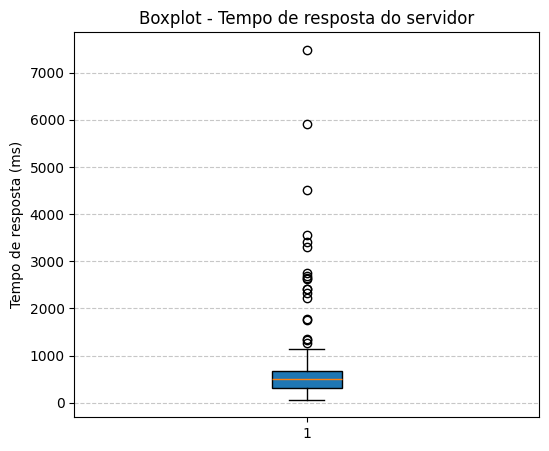

In [20]:
# Filtra apenas valores válidos
df_valid = df[df["latency_ms"].notnull()]

plt.figure(figsize=(6, 5))
plt.boxplot(df_valid["latency_ms"], vert=True, patch_artist=True)

plt.title("Boxplot - Tempo de resposta do servidor")
plt.ylabel("Tempo de resposta (ms)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

Removidos 19 outliers


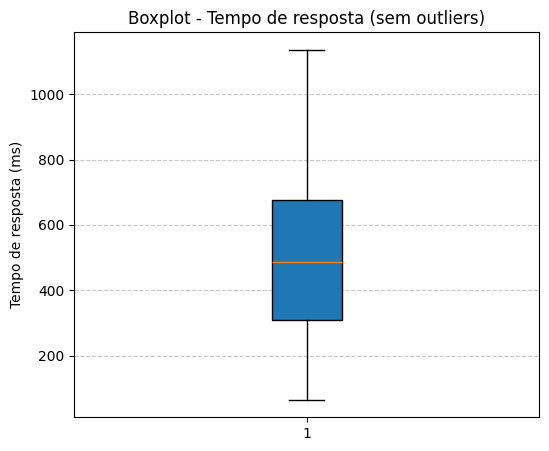

In [21]:
# Supondo que já tenha o DataFrame
df_valid = df[df["latency_ms"].notnull()].copy()

# Calcula Q1 (25%) e Q3 (75%)
Q1 = df_valid["latency_ms"].quantile(0.25)
Q3 = df_valid["latency_ms"].quantile(0.75)
IQR = Q3 - Q1

# Define limites inferior e superior
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtra sem outliers
df_sem_outliers = df_valid[
    (df_valid["latency_ms"] >= limite_inferior) &
    (df_valid["latency_ms"] <= limite_superior)
]

print(f"Removidos {len(df_valid) - len(df_sem_outliers)} outliers")

# Plota boxplot sem outliers
plt.figure(figsize=(6, 5))
plt.boxplot(df_sem_outliers["latency_ms"], vert=True, patch_artist=True)

plt.title("Boxplot - Tempo de resposta (sem outliers)")
plt.ylabel("Tempo de resposta (ms)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()